In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import json
import os
import pickle
import pandas as pd
import argparse # To accept checkpoint path as argument
import sys
root_path = os.path.abspath("..")
DATA_PATH = "/data/MHL/pressing-intensity-feat"
sys.path.append(root_path)

# Import project modules
# import config  # Import static configurations
from model import PytorchSoccerMapModel, exPressModel # Import Lightning model
from datasets import PressingSequenceDataset, exPressInputDataset, SoccerMapInputDataset 
from config import TEAMNAME2ID, TEAMID2NAME
pl.seed_everything(42, workers=True) # For reproducibility


Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


42

In [2]:
test_dataset = exPressInputDataset(os.path.join(DATA_PATH, "test_dataset.pkl"))

Loading dataset from /data/MHL/pressing-intensity-feat/test_dataset.pkl...


In [3]:
pos_cnt = 0
neg_cnt = 0
for sample in test_dataset:
    if sample['label'] == 1:
        pos_cnt += 1
    else:
        neg_cnt += 1
print(pos_cnt, neg_cnt)

172 483


In [4]:
optimizer_params = {
        "optimizer_params": {
            "lr": 1e-4,
            "weight_decay": 1e-5
        }
    }
model_config = {
    "in_channels": 18,
        "num_gnn_layers": 2,
        "gnn_hidden_dim": 64,
        "num_lstm_layers": 2,
        "lstm_hidden_dim": 64,
        "lstm_dropout": 0.4,
        "lstm_bidirectional": True,
        "use_pressing_features": False,
        "gnn_head": 4
}

ckpt_path = "/data/MHL/pressing-intensity-feat/checkpoints/exPress-epoch=192-val_loss=0.51.ckpt"

model = exPressModel.load_from_checkpoint(checkpoint_path=ckpt_path,
                                          model_config=model_config, optimizer_params=optimizer_params)
model = model.to("cuda")


In [5]:
test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        # collate_fn=collate_fn_skip_none
    )

In [11]:
match_id = "153379"
match_path = f"/data/MHL/bepro/processed/{match_id}"

with open(f"{match_path}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)

match_dict.keys()

dict_keys(['tracking_df', 'event_df', 'teams', 'meta_data'])

In [15]:
tracking_df = match_dict['tracking_df']
event_df = pd.read_csv(f"{match_path}/valid_events_filtered2.csv")
teams_dict = match_dict['teams']
home_team = teams_dict['Home'].copy()
away_team = teams_dict['Away'].copy()
meta_data = match_dict['meta_data']

In [16]:
teams_df = pd.concat([home_team, away_team])
teams_df.reset_index(drop=True, inplace=True)
teams_df['player_code'] = teams_df.apply(lambda row : row['team'][0] + str(row['xID']).zfill(2), axis=1)
teams_df.head()

,player,position,team,jID,pID,tID,xID,player_code
0,SHIN CHANGMOO,None,Home,40,345465,4648,0,H00
1,Junsu Byeon,CB,Home,15,500138,4648,1,H01
2,Beka Mikeltadze,None,Home,99,408383,4648,2,H02
3,Taejun Park,CM,Home,55,500142,4648,3,H03
4,Jinho Kim,LB,Home,27,500140,4648,4,H04


In [45]:
for batch in test_loader:
    if not batch['match_info'][0].startswith("153379"): continue
    for key in batch:
        if key in ['features', 'pressing_intensity', 'label']:
            batch[key] = batch[key].to("cuda")
    loss, preds, targets = model.step(batch)
    presser_row = teams_df[teams_df['pID'] == batch['presser_id'][0]]
    pressed_row = teams_df[teams_df['pID'] == batch['pressed_id'][0]]
    presser_name = f"{presser_row['player'].iloc[0]} ({presser_row['jID'].iloc[0]}, {TEAMID2NAME[presser_row['tID'].iloc[0]].split()[0]})"
    pressed_name = f"{pressed_row['player'].iloc[0]} ({presser_row['jID'].iloc[0]}, {TEAMID2NAME[pressed_row['tID'].iloc[0]].split()[0]}')"
    print(f"{batch['match_info'][0]} | Presser: {presser_name} | Pressed Player : {pressed_name} | {round(preds.item(), 4)}, {targets.item()}")

153379-1.0-235 | Presser: Masatoshi Ishida (10, Daejeon) | Pressed Player : Mingi Lee (10, Gwangju') | 0.1453, 0.0
153379-1.0-1020 | Presser: Doyoung Yun (77, Daejeon) | Pressed Player : Huseong Oh (77, Gwangju') | 0.6251, 0.0
153379-1.0-1356 | Presser: Masatoshi Ishida (10, Daejeon) | Pressed Player : Mingi Lee (10, Gwangju') | 0.0766, 0.0
153379-1.0-1863 | Presser: Hoyeon Jeong (14, Gwangju) | Pressed Player : Victor Bobsin (14, Daejeon') | 0.2389, 0.0
153379-1.0-2061 | Presser: Munhwan Kim (95, Daejeon) | Pressed Player : Huseong Oh (95, Gwangju') | 0.3811, 0.0


153379-1.0-2524 | Presser: Masatoshi Ishida (10, Daejeon) | Pressed Player : Mingi Lee (10, Gwangju') | 0.1384, 1.0
153379-1.0-2982 | Presser: Junbum Kim (14, Daejeon) | Pressed Player : Taejun Park (14, Gwangju') | 0.3644, 0.0
153379-1.0-3255 | Presser: Jasir Asani (7, Gwangju) | Pressed Player : Anton Krivotsyuk (7, Daejeon') | 0.0919, 1.0
153379-1.0-4458 | Presser: Jinho Kim (27, Gwangju) | Pressed Player : Masatoshi Ishida (27, Daejeon') | 0.5923, 1.0
153379-1.0-4854 | Presser: Huigyun Lee (10, Gwangju) | Pressed Player : Geonju Choi (10, Daejeon') | 0.6677, 0.0
153379-1.0-6105 | Presser: Seonggwon Cho (2, Gwangju) | Pressed Player : Doyoung Yun (2, Daejeon') | 0.5871, 0.0
153379-1.0-6707 | Presser: Geonju Choi (47, Daejeon) | Pressed Player : Kyeongmin Kim (47, Gwangju') | 0.2287, 1.0
153379-1.0-7148 | Presser: Doyoung Yun (77, Daejeon) | Pressed Player : Jinho Kim (77, Gwangju') | 0.0543, 0.0
153379-1.0-7846 | Presser: Masatoshi Ishida (10, Daejeon) | Pressed Player : Huigyun Lee

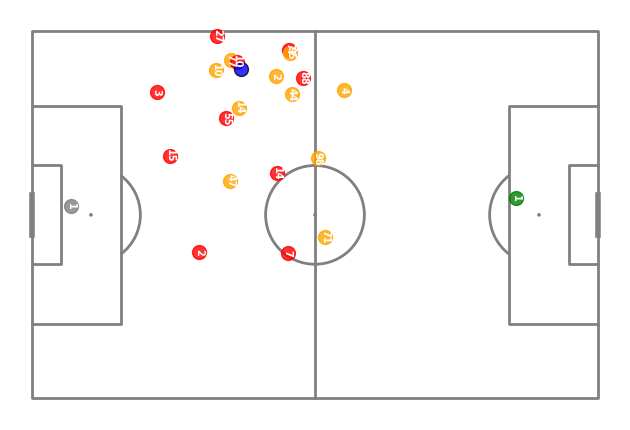

In [25]:
plot_single_frame_positions(tracking_df, period_id=1, frame_idx=frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

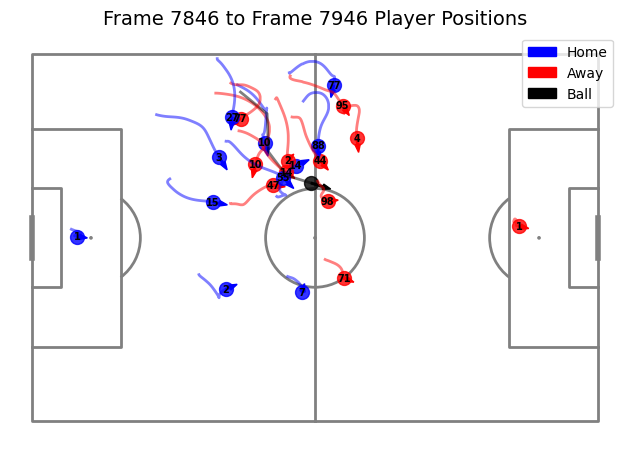

In [24]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

frame_id = 7846
plot_window_frame_positions(tracking_df, period_id=1, start_frame_idx=frame_id, end_frame_idx = frame_id+100, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])